<a href="https://colab.research.google.com/github/tetianasokolova/computer-vision-project/blob/main/CNN_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Baseline Model for Training from Scratch
A simple convolutional neural network implemented in PyTorch to establish a baseline accuracy before experimenting with advanced architectures and fine-tuning.


In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from collections import defaultdict

## Load the dataset Animals-10
Connect to Google Drive account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip in Colab's temporary storage
zip_path = "/content/drive/MyDrive/NaUKMAProgramming/DeepLearning/Data/Animals-10.zip"
data_path = "/content/raw-img"  # Extract in Colab's temporary storage

if not os.path.exists(data_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")  # Extract directly to /content/

In [ ]:
# Load the data
data = datasets.ImageFolder(root=data_path)

There are 26,179 images in Animal-10 dataset.

In [ ]:
len(data)

26179

Check classes of the data. We see that there are 10 classes of animals.

In [ ]:
# Check class-to-index mapping
data.classes

['cane',
 'cavallo',
 'elefante',
 'farfalla',
 'gallina',
 'gatto',
 'mucca',
 'pecora',
 'ragno',
 'scoiattolo']

Translate classes names from Italian to English using dictionary from Python file in the data archiv.

In [ ]:
translate = {"cane": "dog",
             "cavallo": "horse",
             "elefante": "elephant",
             "farfalla": "butterfly",
             "gallina": "chicken",
             "gatto": "cat",
             "mucca": "cow",
             "pecora": "sheep",
             "ragno": "spider",
             "scoiattolo": "squirrel"}

In [ ]:
data.classes = [translate.get(name, name) for name in data.classes]
data.class_to_idx = {name: idx for idx, name in enumerate(data.classes)}

In [ ]:
data.classes

['dog',
 'horse',
 'elephant',
 'butterfly',
 'chicken',
 'cat',
 'cow',
 'sheep',
 'spider',
 'squirrel']

## Transform data
Set up data transformations for train, validation and test datasets. Add data augmentation to data transformation for train. We use the same data transformations for validation and test.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(),   # Flip the image horizontally with probability 0.5
    transforms.RandomRotation(20),   # Rotate the image randomly by up to 10 degrees
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Scale pixel values from [0, 255] to [0, 1] and flip image format from H x W x C to C x H x W
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Mean value for channels, sgd for channels; scale from [0,1] to [-1,1]
])

## Split data into train, validation and test
65% - train data, 15% - validation data and 20% - test data.

In [ ]:
train_ds, val_ds, test_ds = random_split(data, [0.65, 0.15, 0.2])

Create a class TransformedSubset to apply separate transformation to each subset after split.

In [ ]:
class TransformedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

Apply data transformations to each subset.

In [ ]:
train_ds = TransformedSubset(train_ds, transform=train_transform)
val_ds = TransformedSubset(val_ds, transform=val_transform)
test_ds = TransformedSubset(test_ds, transform=test_transform)

Check size of each dataset after split.

In [ ]:
len(train_ds), len(val_ds), len(test_ds)

(17017, 3927, 5235)

Make dataloaders for train, validaton and test data to simplify loading process by batches.

In [ ]:
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
!pip install ann_visualizer

  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4169 sha256=2a3e350690384ef0ad5b1c7de2d88d0c471ff10ee71aab76dc5b6b9d62220ee3
  Stored in directory: /root/.cache/pip/wheels/28/4a/ad/e82da1aad2994e42bf0f4b1d403fdd8a64dfc38ae2c8a5daa4
Successfully built ann_visualizer


In [ ]:
from ann_visualizer.visualize import ann_viz
from torchsummary import summary

## Define CNN architecture

Create a model with 4 convolutional layers followed by 2 fully-connected layers and output layer. We use 5x5 filter for the first layer and 3x3 filters for other convolutional layers, with padding to preserve the dimension of the picture. As activation function ReLU is used and max pooling is added. Add batch normalization to convolutional layers and dropout to fully-connected layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256*14*14, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 10)  # Output layer (logits)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out)

        out = self.conv4(out)
        out = self.bn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)

        out = out.view(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu5(out)

        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu6(out)

        out = self.fc3(out)
        return out

In [ ]:
model = CNN()

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Move model to GPU
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rel

## Train the model

In [ ]:
# Function to evaluate mode
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = total_loss / len(dataloader)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return val_loss, accuracy, f1

# Train the model
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1s, val_f1s = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_dl)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_loss, val_accuracy, val_f1 = evaluate_model(model, val_dl)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")


Epoch 1/20: Train Loss: 2.2382, Train Acc: 0.2447, Train F1: 0.2094 | Val Loss: 1.9195, Val Acc: 0.3239, Val F1: 0.2828
Epoch 2/20: Train Loss: 1.8286, Train Acc: 0.3612, Train F1: 0.3197 | Val Loss: 1.7258, Val Acc: 0.3990, Val F1: 0.3452
Epoch 3/20: Train Loss: 1.6953, Train Acc: 0.4178, Train F1: 0.3831 | Val Loss: 1.5440, Val Acc: 0.4787, Val F1: 0.4447
Epoch 4/20: Train Loss: 1.5974, Train Acc: 0.4531, Train F1: 0.4286 | Val Loss: 1.4636, Val Acc: 0.5075, Val F1: 0.4816
Epoch 5/20: Train Loss: 1.5044, Train Acc: 0.4843, Train F1: 0.4640 | Val Loss: 1.3726, Val Acc: 0.5455, Val F1: 0.5046
Epoch 6/20: Train Loss: 1.4104, Train Acc: 0.5230, Train F1: 0.5065 | Val Loss: 1.2864, Val Acc: 0.5826, Val F1: 0.5671
Epoch 7/20: Train Loss: 1.3091, Train Acc: 0.5556, Train F1: 0.5412 | Val Loss: 1.2329, Val Acc: 0.5931, Val F1: 0.5686
Epoch 8/20: Train Loss: 1.2459, Train Acc: 0.5763, Train F1: 0.5643 | Val Loss: 1.1561, Val Acc: 0.6155, Val F1: 0.6044
Epoch 9/20: Train Loss: 1.1766, Train Ac

## Save the model

In [ ]:
torch.save(model, 'model_full.pth')

## Evaluate the model on test data

In [ ]:
from sklearn.metrics import classification_report

predicted_labels = []
true_labels = []

model.eval()   # Set to evaluation mode
with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Calculate metrics
report = classification_report(true_labels, predicted_labels, target_names=data.classes, digits=4)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

         dog     0.6895    0.7925    0.7374      1017
       horse     0.7937    0.6362    0.7063       514
    elephant     0.7944    0.7269    0.7592       271
   butterfly     0.7967    0.8102    0.8034       411
     chicken     0.8971    0.7687    0.8280       601
         cat     0.7290    0.4800    0.5788       325
         cow     0.6974    0.4871    0.5736       388
       sheep     0.6100    0.6952    0.6498       351
      spider     0.7584    0.9420    0.8403       983
    squirrel     0.7139    0.7005    0.7072       374

    accuracy                         0.7454      5235
   macro avg     0.7480    0.7039    0.7184      5235
weighted avg     0.7498    0.7454    0.7404      5235



- Overall accuracy of 74.5% on test data indicats good performance.
- **Best performing classes** are **chicken** (F1 score: 0.8280) and **spider** (F1: 0.8403).
- **Worst performing classes** are **cat** (F1: 0.5788) and **cow** (F1: 0.5736).
- Lower recall in some classes (horse, cow and cat) suggests that the model may favor more frequent classes.

## Visualise train results

We see that the model shows steady improvement over 20 epochs.
- **Training loss** drops from 2.24 to 0.74, and **validation loss** from 1.92 to 0.81, indicating better learning of the model.
- **Training accuracy** rises from 24.5% to 75.6%, and **validation accuracy** from 32.4% to 74.1%, showing good generalization of the model.
- **Train F1 score** improves from 0.21 to 0.75, and **validation F1 score** from 0.28 to 0.74, which suggests balanced precision and recall.

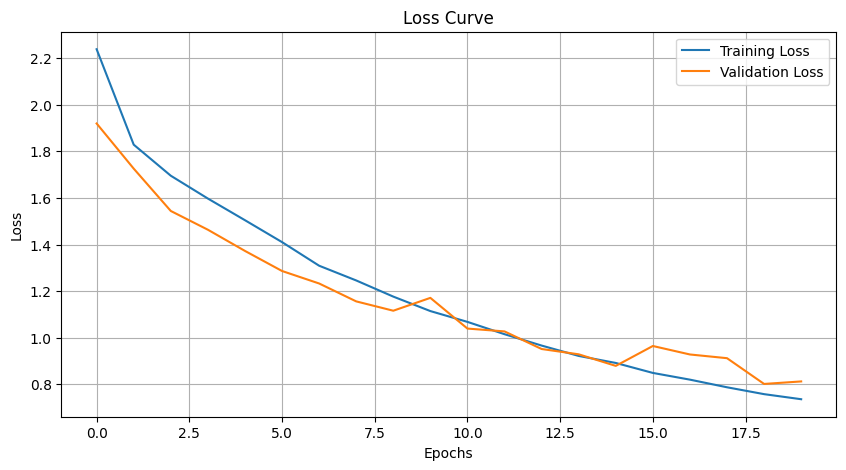

In [ ]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

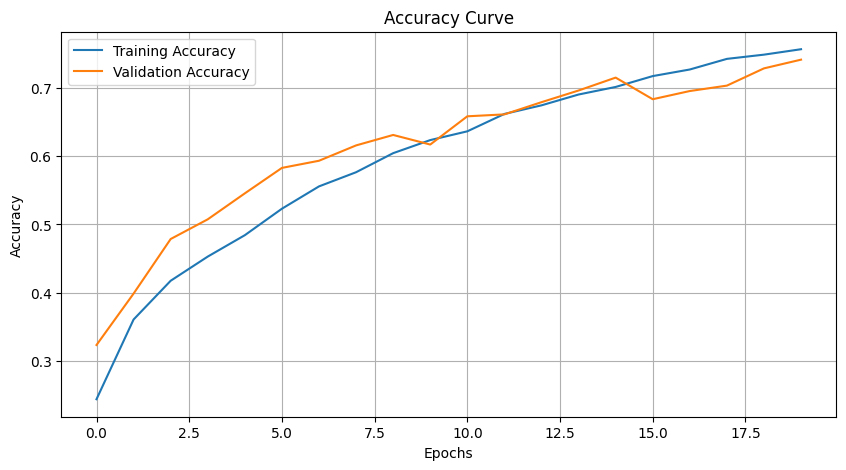

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

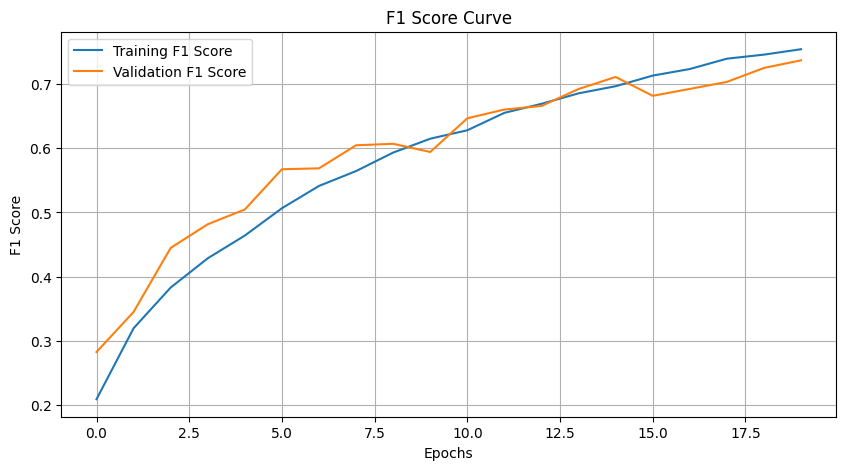

In [ ]:
# Plot F1-score
plt.figure(figsize=(10,5))
plt.plot(train_f1s, label='Training F1 Score')
plt.plot(val_f1s, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.legend()
plt.grid(True)
plt.show()